In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

# Load and check the data

In [2]:
X_full = np.load('./X_train.npy') # Feature description of training sample objects
Y_full = np.load('./y_train.npy') # Target variable values on the training sample
print('Dataset shape: {}\nTarget vector shape: {}'.format(X_full.shape, Y_full.shape))
print('X:', X_full[0:5])
print('Y:', Y_full[0:5])

Dataset shape: (10000, 4)
Target vector shape: (10000, 1)
X: [[  -1.37985929   -1.6392424     1.90401167   -2.62726819]
 [  -5.41159781   -5.49543837   29.28539091 -158.48075746]
 [  -4.29978581   -4.59480326   18.48815797  -79.49511923]
 [  -6.00513656   -5.9213484    36.06166512 -216.55522367]
 [  -6.4203386    -6.36417221   41.22074779 -264.65115829]]
Y: [[2.46862556]
 [9.99814558]
 [9.27899993]
 [8.63480621]
 [9.56711056]]


Let's check the features for correlation

[]

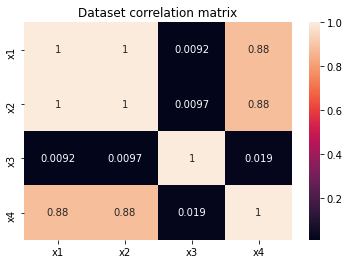

In [3]:
df = pd.DataFrame(data = X_full, columns = ['x1', 'x2', 'x3', 'x4'])
corr_matrix = df.corr() # compute correlation matrix
sns.heatmap(corr_matrix, annot = True)
plt.title('Dataset correlation matrix')
plt.plot()

As we can see, features __x1__ and __x2__ are _linearly dependent_    
and __x4__ is _strongly correlated_ with __x1__  
Thus we can _remove_ __x1__ from our dataset.  
Also we can remove __x4__, but I'll do it just to visualize data

Divide our dataset into __training set__, __cross-validation set__, and __test set__    
__X_train__ - training set  
__X_valid__ - cross-validation set  
__X_test__ - test set  
10 % of __X_full__ goes to cross-validation set, the same with test set  
We do the same with __Y_full__.

In [4]:
m = X_full.shape[0] # number of training examples
# We'll copy original dataset to avoid changing it
# 80% to training set
cut1 = np.floor(m * 0.8).astype('int64') # train / cross-valid. sets
cut2 = cut1 + (m - cut1)//2              # cross-valid. / test sets 
# Also we remove feature #1 from the dataset
X_train = X_full[:cut1, 1:].copy()
Y_train = Y_full[:cut1].copy()
# 10% to cross-valid. set
X_valid = X_full[cut1:cut2, 1:].copy()
Y_valid = Y_full[cut1:cut2].copy()
# 10% to test set
X_test = X_full[cut2:, 1:].copy()
Y_test = Y_full[cut2:].copy()

# Check that we have divided everything correctly:
is_correct = (m == (X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]))
print('Division is correct: {}\n'.format(is_correct))
print('X_train shape: {}\nX_valid shape: {}\nX_test shape:  {}'.format(X_train.shape, X_valid.shape, X_test.shape))

Division is correct: True

X_train shape: (8000, 3)
X_valid shape: (1000, 3)
X_test shape:  (1000, 3)


# Visualize data
We will remove feature __x4__ from our dataset to visualize data

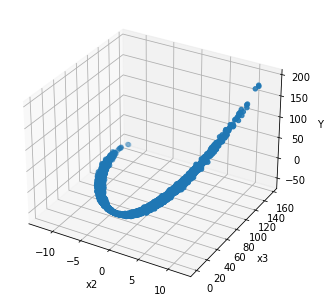

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = Axes3D(fig)

x_vals = df['x2']
y_vals = df['x3']
z_vals = Y_full

ax.scatter(x_vals, y_vals, z_vals)

ax.set_xlabel('x2')
ax.set_ylabel('x3')
ax.set_zlabel('Y')

plt.show()

We can see that relationships between features and target values are nonlinear,  
thus we need to add some polynomial features

# Building a model

We will use the __MSE__ loss function, divided by _2m_, where _m_ is a number of training examples

In [6]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

In [7]:
class loss(Differentiable):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        m = y_true.shape[0]
        
        loss_value = 1/(2*m) * np.sum((y_pred - y_true)**2)
        
        return loss_value
    
    def backward(self, y_pred, y_true):
        partial_grad = np.zeros_like(y_pred - y_true)
        
        partial_grad = 1/m * (y_pred - y_true)
        
        return partial_grad

In [8]:
class linear_regression(Differentiable):
    
    def __init__(self):
        super().__init__()
        self.theta = None
    
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, X):
        eye_column = np.eye(X.shape[0], 1)
        X = np.concatenate((eye_column, X), axis = 1)
        partial_grad = X.T
        return partial_grad
        
    def forward(self, X):
        
        assert X.ndim == 2, "X should be 2-dimensional: (m of objects, n of features)"
        
        if self.theta is None:
            
            self.theta = np.zeros((X.shape[1] + 1, 1))
           
        eye_column = np.eye(X.shape[0], 1)
        X = np.concatenate((eye_column, X), axis = 1)
        y_pred = np.dot(X, self.theta)
        
        return y_pred

In [9]:
def predict_err(X, y, model):
    """
    Returns:
    Prediction error, calculated by MAE
    """
    y_pred = model.forward(X)
    error = 1/X.shape[0] * np.sum(np.abs(y-y_pred))
    
    return error

In [10]:
def plot_cost(loss_history, loss_valid_history, learning_rate = 0.001, lambd = 0):
    # Plot loss function
    plt.figure(1)
    plt.plot(loss_valid_history[:,0], label = 'Dev set')
    plt.plot(loss_history[:,0], label = 'Training set')
    plt.title('Cost with learning rate = {}, lambda = {}'.format(learning_rate, lambd))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # Plot error
    plt.figure(2)
    plt.plot(loss_valid_history[:, 1], label = 'Dev set')
    plt.plot(loss_history[:, 1], label = 'Training set')
    plt.title('Prediction error')
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.legend()

    print('Prediction error on training set: {}'.format(predict_err(X_train, Y_train, lr_model)))
    print('Prediction error on cross-validation set: {}'.format(predict_err(X_valid, Y_valid, lr_model)))
    print('Prediction error on test set: {}'.format(predict_err(X_test, Y_test, lr_model)))

In [11]:
def train_loop(X, y, X_valid, y_valid, model, loss_fn, epochs = 100, lr_rate = 0.001):
    loss_history = list()
    loss_valid_history = list()
    pbar = tqdm(total = epochs)
    for epoch in range(epochs):
        
        y_pred = model.forward(X)
        y_pred_valid = model.forward(X_valid)
        
        loss_value = (loss_fn.forward(y_pred, y), predict_err(X, y, model))
        loss_value_valid = (loss_fn.forward(y_pred_valid, y_valid), predict_err(X_valid, y_valid, model))
        grad = np.dot(model.backward(X), loss_fn.backward(y_pred, y)) 
        model.theta = model.theta - lr_rate*grad
        
        loss_history.append(loss_value)
       # if (epoch % 100 == 0):
        #    print('Training cost after {} epochs: {}'.format(epoch, loss_value))
        loss_valid_history.append(loss_value_valid)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value[0]})
        
    pbar.close()
    return np.array(loss_history), np.array(loss_valid_history)

In [12]:
loss_fn = loss()
lr_model = linear_regression()
lr_rate = 0.00001 # learning rate
loss_history, loss_valid_history = train_loop(X_train, Y_train, X_valid, Y_valid, lr_model, loss_fn, lr_rate = lr_rate, epochs = 1000)

100%|████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 462.62it/s, loss=6.07]


Prediction error on training set: 3.0017681437272983
Prediction error on cross-validation set: 3.7858903496780023
Prediction error on test set: 3.5596001232064607
Parameters: [[ 1.66871886e-06]
 [-7.17651684e-02]
 [ 5.18491257e-01]
 [ 5.67462860e-02]]


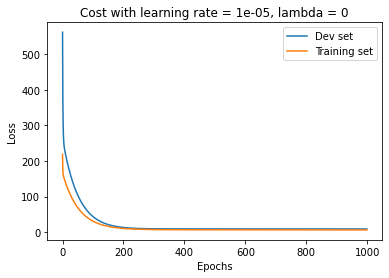

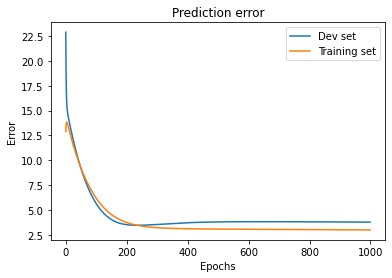

In [13]:
plot_cost(loss_history, loss_valid_history, lr_rate)
print('Parameters: {}'.format(lr_model.theta))

# Conclusion
Due to strong difference between errors of training set and dev set, we have a problem of _high variance_  .  
Stopping after ~250 epochs may prevent overfitting.

100%|██████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 445.22it/s, loss=7.96]


Prediction error on training set: 3.3821075013009656
Prediction error on cross-validation set: 3.473629054388503
Prediction error on test set: 3.3035533262992596
Parameters: [[ 4.93740038e-07]
 [-1.92548595e-02]
 [ 4.69831283e-01]
 [ 5.42484351e-02]]


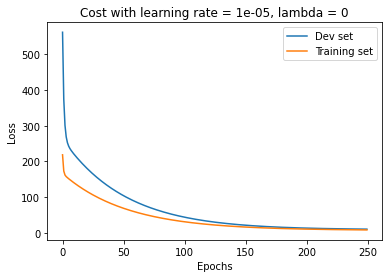

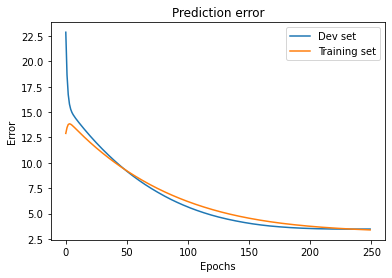

In [14]:
loss_fn = loss()
lr_model = linear_regression()
lr_rate = 0.00001 # learning rate
loss_history, loss_valid_history = train_loop(X_train, Y_train, X_valid, Y_valid, lr_model, loss_fn, lr_rate = lr_rate, epochs = 250)

plot_cost(loss_history, loss_valid_history, lr_rate)
print('Parameters: {}'.format(lr_model.theta))

We can compute error in the next way:  
- Compute mean target value for each set
- Divide error by an absolute error and multiply by 100%

In [15]:
y_mean_train = np.mean(Y_train)
y_mean_valid = np.mean(Y_valid)
y_mean_test = np.mean(Y_test)

print('Training relative error: {} %'.format(100*predict_err(X_train, Y_train, lr_model) / y_mean_train))
print('Cross-validation relative error: {} %'.format(100*predict_err(X_valid, Y_valid, lr_model) / y_mean_valid))
print('Test relative error: {} %'.format(100*predict_err(X_test, Y_test, lr_model) / y_mean_test))

Training relative error: 27.124110632525934 %
Cross-validation relative error: 15.356182407789301 %
Test relative error: 14.421860141593848 %


In [16]:
Y_pred_test = lr_model.forward(X_test[200:205])
print('Predicted\n', Y_pred_test)
print('Actual\n', Y_test[200:205])

Predicted
 [[ 3.73989613]
 [21.46192048]
 [49.67473908]
 [34.87614812]
 [10.9094006 ]]
Actual
 [[-0.85599998]
 [19.21453372]
 [52.42143235]
 [35.03816172]
 [ 5.82214592]]


It seems that the biggest error is obtained at small target values

In [17]:
print(y_mean_train, y_mean_valid, y_mean_test)
# Let's check this hypothesis on values that are less then mean value 
print(predict_err(X_test[np.squeeze(Y_test < 100000000000)], Y_test[Y_test < 100000000000], lr_model))

12.469007913738947 22.62039458860903 22.906568874368265
23200.662768140093
